# Explosive Narratives: Terrorism through the Cinematic Lens
## Boat2023 Milestone 2

In this preparatory part of the project, we agreed on our project proposal; the impact on terrorism on cinema. We performed initial analyses including data exploration, data pre-processing and initial data visualizations, all in relation to our research questions: emotional depiction of terrorism-related movies, genre association, topic analysis as well as popularity.

In [1]:
from helpers import *

#useful imports
import xml.etree.ElementTree as ET
import pandas as pd
from typing import Dict
import json
import re

#important libraries for data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from scipy import stats
import statsmodels.formula.api as smf


#important libraries for the Sentiment analysis
from scipy.signal import savgol_filter
import nltk
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

FILE_ID = '1UKCPLE0QpJGDncD6zvXfSIil0pRlCj-c'
LOCAL_FILE_NAME='local_title_data.tsv'

ImportError: cannot import name 'is_ascii' from 'charset_normalizer.utils' (/Users/macdesarah/opt/anaconda3/envs/ADA/lib/python3.9/site-packages/charset_normalizer/utils.py)

In [2]:
download_data(FILE_ID,LOCAL_FILE_NAME)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1UKCPLE0QpJGDncD6zvXfSIil0pRlCj-c
From (redirected): https://drive.google.com/uc?id=1UKCPLE0QpJGDncD6zvXfSIil0pRlCj-c&confirm=t&uuid=7b6d3259-96cf-42a0-beff-9bfdd11478b6
To: /Users/bina/Documents/MA1/ada-2023-project-boat2023/local_title_data.tsv
100%|██████████| 885M/885M [01:00<00:00, 14.7MB/s] 


## 1. Data Pre-processing

### 1.1 Import Data

In [3]:
plot_path= 'data/plot_summaries.txt'
movie_metadata_path = 'data/movie.metadata.tsv'
external_title_path= LOCAL_FILE_NAME
external_rating_path= 'data/data.tsv'

In [4]:
m_plot = pd.read_csv(plot_path, delimiter='\t', header= None)
m_column_names = ['W_movie ID', 'F_movie ID', 'Movie name', 'Release date', 'Box office revenue', 'Runtime', 'Languages', 'Countries', 'Genres']
m_data = pd.read_csv('data/movie.metadata.tsv', delimiter= '\t',on_bad_lines='skip', names=m_column_names, header=0)
rating_data=pd.read_csv(external_rating_path,delimiter='\t', on_bad_lines='skip', header=0)
external_title= pd.read_csv(external_title_path,delimiter='\t', on_bad_lines='skip', header=0)

/var/folders/67/6c4p9l3d6gz7mdpq5tr7rk7w0000gn/T/ipykernel_3768/2205135396.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  external_title= pd.read_csv(external_title_path,delimiter='\t', on_bad_lines='skip', header=0)


In [ ]:
m_data.head(5)

When displaying the dataframe, we notice that the columns Countries, Languages and Genres include some kind of ID, in addition to the readable value we are interest in (for example {"/m/0chghy": "Australia"}). To get a more visually pleasing dataframe, we use the JSON library as follows.

In [ ]:
# Function to extract the readable values from the strings
def extract_values(text):
    try:
        # Load the text as JSON and extract values
        data_dict = json.loads(text)
        return ', '.join(data_dict.values())
    except json.JSONDecodeError:
        # If it's not valid JSON, try to find all readable parts with regex
        return ', '.join(re.findall(r'":\s*"([^"]+)"', text))

# Apply the function to clean the columns of our dataframe
m_data['Countries'] = m_data['Countries'].apply(extract_values)
m_data['Languages'] = m_data['Languages'].apply(extract_values)
m_data['Genres'] = m_data['Genres'].apply(extract_values)
display(m_data)

### 1.2 Filter Terrorism-Related Movies and Other Movies

Since our research focuses on the impact of terrorism on movies, we need to filter the dataset to solely target movies related to terrorism. We did some research and crafted a list of keywords of the terrorism lexicon, mainly based on information from Wikipedia. We used this list to create a subset of our original dataset, that we will use for all our analyses.

In [ ]:
KEYWORDS = [ "Terrorism", "Terrorist", "Terrorists", "Jihad", "Extremism", "Extremist", "Attacks", "Attack", "Bombs", "Bombing", "Bombers", 
            "Hijack", "Hijacking", "Kidnap", "Kidnapping", "Counterterrorism", "Counterterrorist", "Radicalization", "Radicalized", 
            "Security Threat", "Political Violence", "Suicide Bomber", "War on Terror", "Homeland Security", "National Security", "Intelligence Agencies", 
            "Counterinsurgency", "Terrorist Cells", "Radical Ideology", "Terrorist Plot", "Terrorist Organization", "Hostage Crisis", "Terrorism Investigation", 
            "Counterterrorist Operation", "Radical", "Guerrilla Warfare", "Insurgency", "Terror Threat", "Covert Operations", "Political Unrest", "Martyrdom", 
            "Cyberterrorism", "Terrorism Financing", "Violent Extremism", "Terrorist Recruitment", "Suicide Attacks", "Terrorist Sleeper Cells", 
            "Counterterror Measures", "Clandestine Activities", "Security Intelligence" ]

In [5]:
movie_ids=[]
# Create a new column in the DataFrame to store the count of keywords in each movie plot
for index, row in m_plot.iterrows():
    movie_id = row[0]
    plot = row[1]
    # Check if the plot contains any of the keywords
    for keyword in KEYWORDS:
        if keyword.lower() in plot:
            movie_ids.append(movie_id)
# Display the list of movie IDs that match the keywords
movie_ids= set(movie_ids)

In [6]:
# Terrorism-related movies
terrorism_movies = m_data[m_data['W_movie ID'].isin(movie_ids)][['W_movie ID','Movie name', 'Release date','Countries', 'Languages', 'Genres','Box office revenue']]
terrorism_movies = terrorism_movies.sort_values(by=['Release date'])
display(terrorism_movies) 

In [ ]:
#Keeping all the movies with box office
revenue_data = m_data.dropna(subset=['Box office revenue'])
#Keeping terrorism movies with box office
other_movies= revenue_data[~revenue_data['W_movie ID'].isin(movie_ids)][['W_movie ID','Movie name', 'Release date','Countries', 'Languages', 'Genres','Box office revenue']]

In [7]:
df_plot = m_plot.rename(columns={0: 'W_movie ID', 1: 'summary'})
df_for_topics = pd.merge(terrorism_movies, df_plot, on='W_movie ID', how='inner')
df_for_topics.drop('Box office revenue', axis =1, inplace=True)
df_for_topics.head(3)

,W_movie ID,Movie name,Release date,Countries,Languages,Genres,summary
0,9633533,Vandanam,1989,"{""/m/03rk0"": ""India""}","{""/m/0999q"": ""Malayalam Language""}","{""/m/02kdv5l"": ""Action""}","Professor Kurian Fernandez , a convict escapes..."
1,261237,The Gods Must Be Crazy,1980,"{""/m/0hzlz"": ""South Africa""}","{""/m/0x82"": ""Afrikaans Language"", ""/m/02h40lc""...","{""/m/03k9fj"": ""Adventure"", ""/m/03btsm8"": ""Acti...",The film is a collision of three separate stor...
2,4951456,Kinjite: Forbidden Subjects,1989,"{""/m/09c7w0"": ""United States of America""}","{""/m/02h40lc"": ""English Language""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/03btsm8"": ""A...",A Japanese businessman sees a woman being grop...


### 1.3 Remove Nan Values

In [8]:
terrorism_movies = terrorism_movies.sort_values(by=['Release date'])
terrorism_movies['Release date']=  terrorism_movies['Release date'].str[:4]
terrorism_movies.dropna(subset=['Release date'], inplace=True)

## 2.Data wrangling

In [9]:
other_movies = other_movies.sort_values(by=['Release date'])
other_movies['Release date']=  other_movies['Release date'].str[:4]
other_movies.dropna(subset=['Release date'], inplace=True)

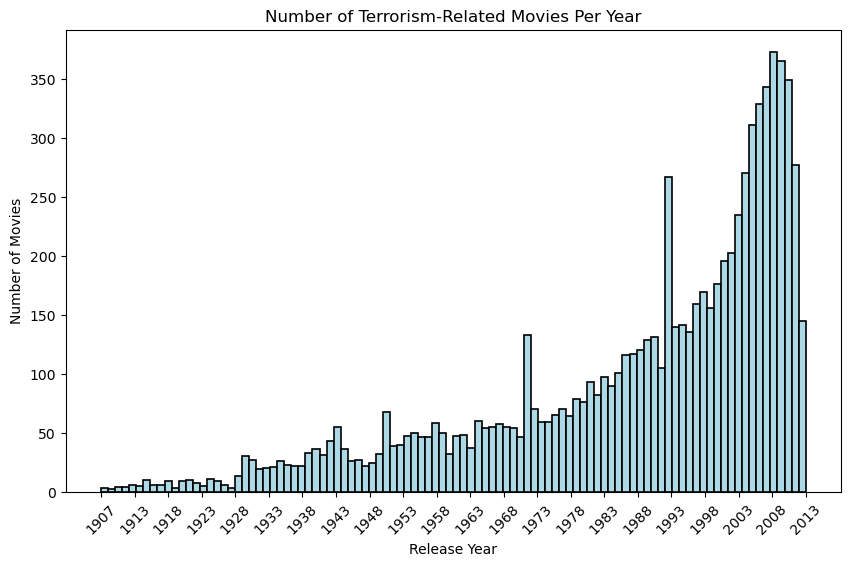

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.hist(terrorism_movies['Release date'],bins= 100, linewidth=1.2, edgecolor='black', color='lightblue')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
min_year = int(terrorism_movies['Release date'].min())
max_year = int(terrorism_movies['Release date'].max())
plt.title('Number of Terrorism-Related Movies Per Year')
ax.set_xticks(ax.get_xticks()[::5])
plt.xticks(rotation=45)
plt.show()


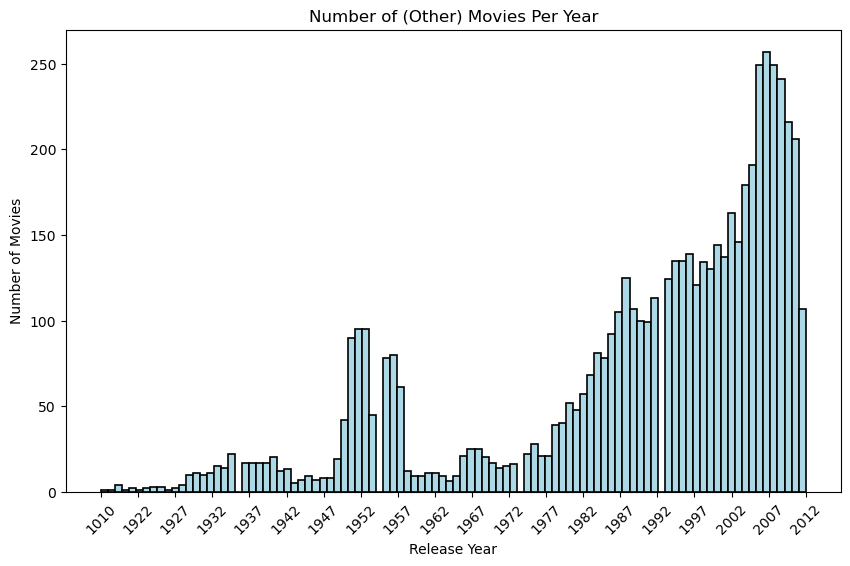

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.hist(other_movies['Release date'],bins= 100, linewidth=1.2, edgecolor='black', color='lightblue')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
min_year = int(terrorism_movies['Release date'].min())
max_year = int(terrorism_movies['Release date'].max())
plt.title('Number of (Other) Movies Per Year')
ax.set_xticks(ax.get_xticks()[::5])
plt.xticks(rotation=45)
plt.show()


### **2.4 How popular are terrorism-related movies in comparison to others?**

#### 4.1.1 Statistics of Box Office Collections & Visualizations

<function matplotlib.pyplot.show(close=None, block=None)>

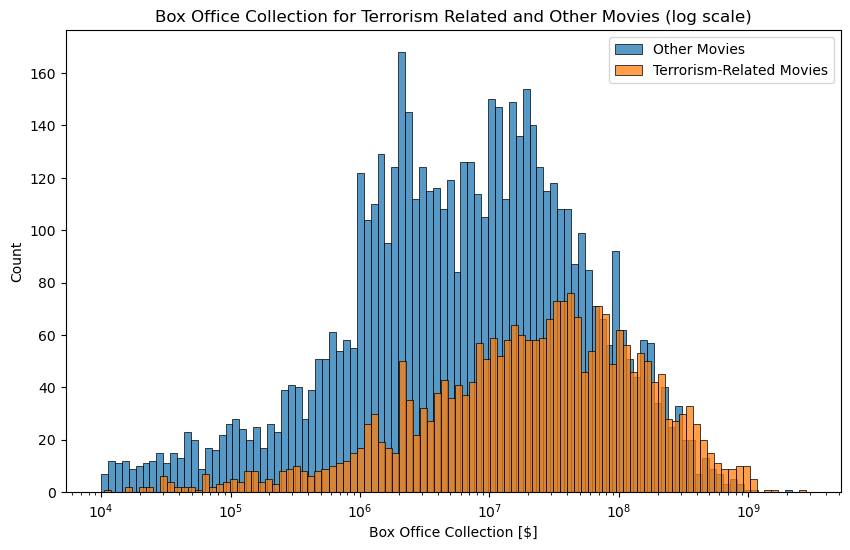

In [12]:
other_movies = other_movies.dropna(subset=['Box office revenue'])

fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(other_movies['Box office revenue'], bins=100, log_scale=True, label='Other Movies')
sns.histplot(terrorism_movies['Box office revenue'], bins=100, log_scale=True, label= 'Terrorism-Related Movies')
plt.title('Box Office Collection for Terrorism Related and Other Movies (log scale)')
plt.xlabel('Box Office Collection [$]')
plt.legend()
plt.show


We observed that the box office revenue distribution exhibits a heavy tail. Consequently, rather than focusing on the mean, 23 consider the log-transformed values of the box office collection.

In [13]:
terro_log_revenue= np.log1p(terrorism_movies['Box office revenue'])
others_log_revenue= np.log1p(other_movies['Box office revenue'])

terror_log_revenue_mean= terro_log_revenue.mean()
others_log_revenue_mean= others_log_revenue.mean()

print(terror_log_revenue_mean)
print(others_log_revenue_mean)

16.824938751643955
15.624203760130868


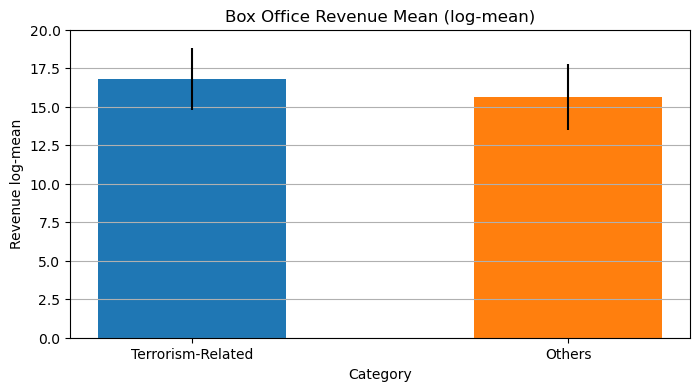

In [14]:
fig, ax = plt.subplots(figsize=(8,4))
categories= ['Terrorism-Related','Others']
log_means= [terror_log_revenue_mean,others_log_revenue_mean]
uncertainties = [np.std(terro_log_revenue, ddof=1), np.std(others_log_revenue, ddof=1)]


for i in range(2):
    plt.bar(categories[i], log_means[i], yerr=uncertainties[i], width=0.5)
#plt.bar(, terror_log_revenue_mean)
#plt.bar(, others_log_revenue_mean)
plt.title('Box Office Revenue Mean (log-mean)')
plt.ylabel('Revenue log-mean')
ax.yaxis.grid(True)
plt.xlabel('Category')
plt.ylim([0,20])
plt.show()

In [15]:
print("Statistics of 'Other Movies' box office collections:")
other_movies['Box office revenue'].describe()

Statistics of 'Other Movies' box office collections:


count    5.808000e+03
mean     3.330517e+07
std      8.092528e+07
min      1.000000e+04
25%      1.600000e+06
50%      7.030036e+06
75%      2.755939e+07
max      2.185372e+09
Name: Box office revenue, dtype: float64

In [16]:
print("Statistics of 'Terrorism-related Movies' box office collections:")
terrorism_movies['Box office revenue'].describe()

Statistics of 'Terrorism-related Movies' box office collections:


count    2.519000e+03
mean     8.276545e+07
std      1.581620e+08
min      1.051400e+04
25%      6.106830e+06
50%      2.618663e+07
75%      8.553192e+07
max      2.782275e+09
Name: Box office revenue, dtype: float64

#### 4.1.2 Rating

In [17]:
other_movies= m_data[~m_data['W_movie ID'].isin(movie_ids)][['W_movie ID','Movie name', 'Release date','Box office revenue']]
terrorsim_movies= m_data[m_data['W_movie ID'].isin(movie_ids)][['W_movie ID','Movie name', 'Release date','Box office revenue']]

In [18]:
#extract only movie related information
external_title = external_title[external_title['titleType'] == 'movie']
#merge the rating_data with external_title data on 'tconst'
merge_title_rating= pd.merge(rating_data,external_title,left_on='tconst', right_on='tconst', how='inner')

In [19]:
other_merged= pd.merge(other_movies,merge_title_rating, left_on='Movie name', right_on='originalTitle', how='inner')
other_merged= other_merged.drop_duplicates(subset=['Movie name'])

In [20]:
terrorism_merged= pd.merge(terrorism_movies,merge_title_rating, left_on='Movie name', right_on='originalTitle', how='inner')
terrorism_merged= terrorism_merged.drop_duplicates(subset=['Movie name'])

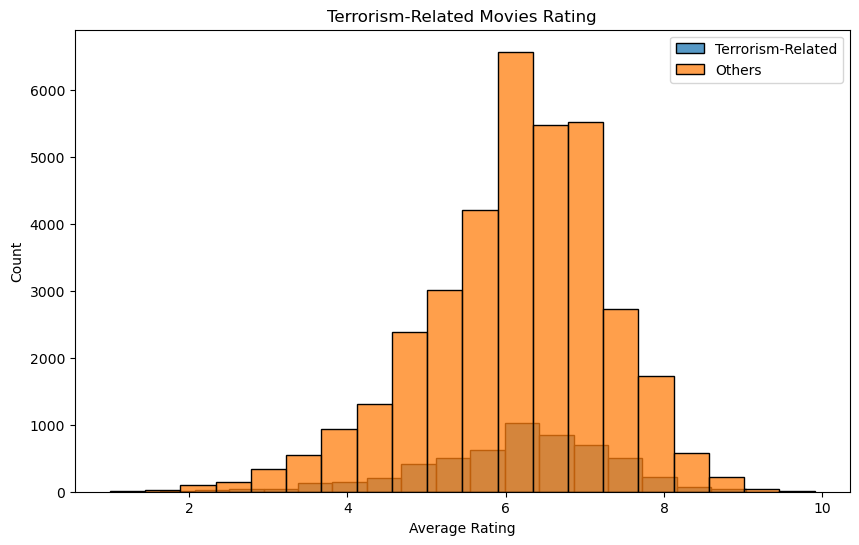

In [21]:
fig, ax = plt. subplots(figsize= (10,6))
sns.histplot(terrorism_merged['averageRating'], bins=20, label='Terrorism-Related')
sns.histplot(other_merged['averageRating'], bins=20, label= 'Others')
plt.title('Terrorism-Related Movies Rating')
plt.xlabel('Average Rating')
plt.legend()
plt.show()

In [22]:
from statsmodels.stats import diagnostic

diagnostic.kstest_normal(terrorism_merged['averageRating'].values, dist = 'norm')

(0.07207119835458575, 0.0009999999999998899)

- p_value < 0.05 -> we can reject the null hypothesis that the data comes from a normal distribution!

In [23]:
diagnostic.kstest_normal(other_merged['averageRating'].values, dist = 'norm')

(0.06341441300821804, 0.0009999999999998899)

- p_value < 0.05 -> we can reject the null hypothesis that the data comes from a normal distribution!

In [24]:
mean_terror_rating= terrorism_merged['averageRating'].mean()
std_terror_rating= np.std(terrorism_merged['averageRating'], ddof=1)

mean_other_rating= other_merged['averageRating'].mean()
std_other_rating= np.std(other_merged['averageRating'],ddof=1)


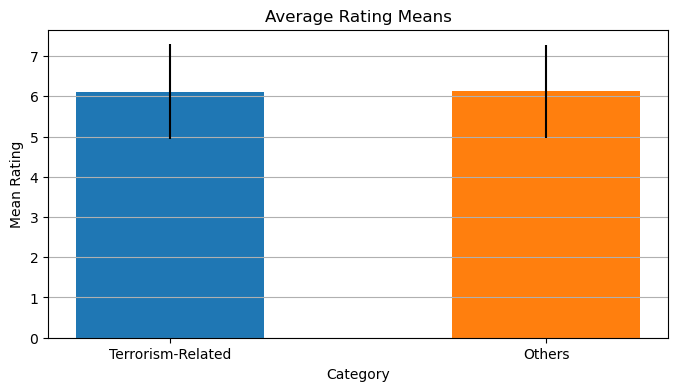

In [25]:
means= [mean_terror_rating, mean_other_rating]
stds= [std_terror_rating,std_other_rating]
cat= ['Terrorism-Related', 'Others']

fig, ax= plt.subplots(figsize= (8,4))
for i in range(2):   
    plt.bar(cat[i], means[i], yerr= stds[i], width=0.5)
    
plt.ylabel('Mean Rating')
ax.yaxis.grid(True)
plt.xlabel('Category')
plt.title('Average Rating Means')
plt.show()
plt.show()

In [26]:
other_merged['averageRating'].describe()

count    35912.000000
mean         6.123137
std          1.152253
min          1.000000
25%          5.500000
50%          6.200000
75%          6.900000
max          9.900000
Name: averageRating, dtype: float64

In [27]:
terrorism_merged['averageRating'].describe()

count    5543.000000
mean        6.117644
std         1.175137
min         1.200000
25%         5.400000
50%         6.300000
75%         6.900000
max         9.900000
Name: averageRating, dtype: float64

#### 4.2 Are there noticeable **topic patterns** in terrorism movies? Do terrorism movies tend to focus on specific themes? If they do, do different countries or regions portray different themes in their cinematic representation of terrorism?

In [28]:
df_plot = m_plot.rename(columns={0: 'W_movie ID', 1: 'summary'})
df_for_topics = pd.merge(terrorism_movies, df_plot, on='W_movie ID', how='inner')
df_for_topics.drop('Box office revenue', axis =1, inplace=True)
df_for_topics.head(3)

,W_movie ID,Movie name,Release date,Countries,Languages,Genres,summary
0,32986669,Robbery Under Arms,1907,"{""/m/0chghy"": ""Australia""}","{""/m/06ppq"": ""Silent film""}","{""/m/06ppq"": ""Silent film"", ""/m/07s9rl0"": ""Dra...",Key scenes of the film included the branding o...
1,7870349,Dr. Jekyll and Mr. Hyde,1908,"{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",Dr. Jekyll and Mr. Hyde began with the raising...
2,29391146,The Black Viper,1908,"{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film""}","{""/m/06ppq"": ""Silent film""}",A thug accosts a girl as she leaves her workpl...


**In this section we remove all rows containing null values for Countries as I will be an essential tool in our computation**



In [29]:
contains_empty_json = df_for_topics['Countries'].apply(is_empty_json)
filtered_df_for_topics = df_for_topics[~contains_empty_json]
filtered_df_for_topics.shape[0]

7934

#### 4.2.1  Number of movies per country

**Now we would like to see how many different countries we can find in our data set in order to check if we can classify the movies per country.**

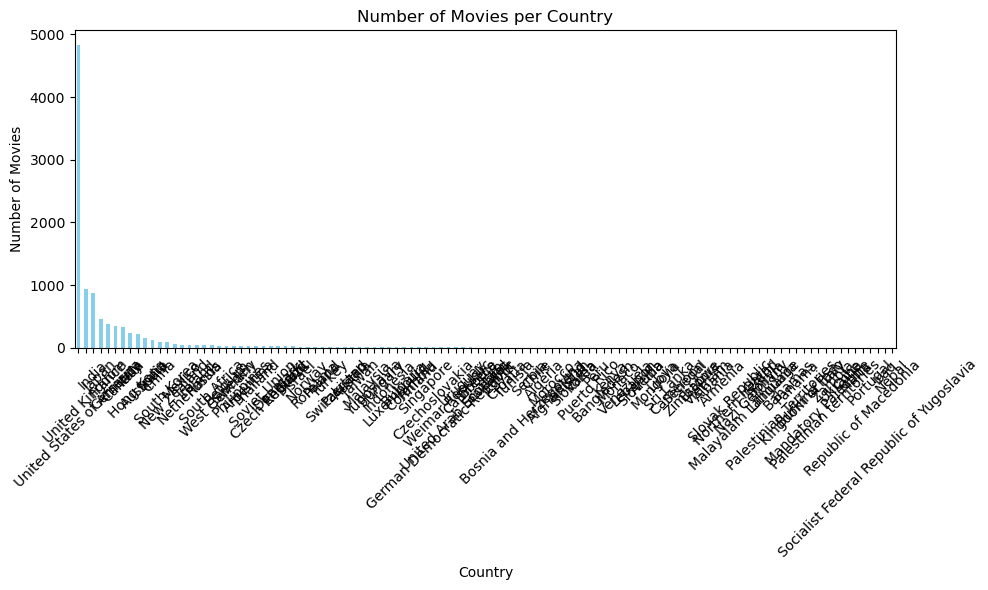

In [30]:
unique_countries = []
for countries_str in filtered_df_for_topics['Countries']:
    unique_countries.extend(extract_countries(countries_str))
# Count the occurrences of each country
country_counts = pd.Series(unique_countries).value_counts()
# Plotting
plt.figure(figsize=(10, 6))
country_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Movies per Country')
plt.xlabel('Country')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**We notice that classifying movies per country is not efficient as there is an imbalanced number of movies per country thus we decided to do a classification per region.**

#### 4.2.2 Number of movies per region

**Data set for regions:** https://www.itu.int/en/ITU-D/Statistics/Pages/definitions/regions.aspx 


In [31]:
df_regions = pd.read_excel('data/Countries_Region.xlsx')
dfs = []
new_df_regions = pd.DataFrame(['Country, Region'])
for i in df_regions.columns:
    region_name = i
    # Create a DataFrame for each region with 'Country' and 'Region' columns
    temp_df = pd.DataFrame({'Country': df_regions[i].dropna(), 'Region': region_name})
    
    # Append each region DataFrame to the list
    dfs.append(temp_df)
new_df_regions = pd.concat(dfs, ignore_index=True)

In [32]:
# Extract unique values from the renamed columns
countries_list = []
for column in df_regions.columns:
        countries_list.extend(df_regions[column].unique().tolist())
unique_countries = set(unique_countries)
countries_not_in_list = [country for country in unique_countries if country not in countries_list]

# Display the list of countries not contained in the 'unique_countries_list'
print("Countries not contained in the unique list:")
print(len(countries_not_in_list))

Countries not contained in the unique list:
31


We noticed that in this data set some countries are not mapped to regions thus we will map them manually:

In [33]:
country_to_region = {
    'United States of America': 'America',
    'West Germany': '​Europ Region',
    'Scotland': '​Europ Region',
    'Taiwan': 'Asia and Pacific',
    'South Korea': 'Asia and Pacific',
    'Monaco': '​Europ Region',
    'Weimar Republic': '​Europ Region',
    'Nepal': 'Asia and Pacific',
    'Iran': '​Arab States',
    'Soviet Union': 'Cis',
    'Nazi Germany': '​Europ Region',
    'Aruba': 'America',
    'Kingdom of Italy': '​Europ Region',
    'Palestinian Territories': '​Arab States',
    'Russia': 'Cis',
    'England': '​Europ Region',
    'Yugoslavia': '​Europ Region',
    'Puerto Rico': 'America',
    'Palestinian territories': '​Arab States',
    'Vietnam': 'Asia and Pacific',
    'Hong Kong': 'Asia and Pacific',
    'Socialist Federal Republic of Yugoslavia': '​Europ Region',
    'Bolivia': 'America',
    'Korea': 'Asia and Pacific',
    'Slovak Republic': '​Europ Region',
    'Malayalam Language': 'Asia and Pacific',
    'Republic of Macedonia': '​Europ Region',
    'Czechoslovakia': '​Europ Region',
    'Mandatory Palestine': '​Arab States',
    'German Democratic Republic': '​Europ Region',
    'Northern Ireland': '​Europ Region'
}

In [36]:
country_to_region_df = pd.DataFrame(country_to_region.items(), columns=['Country', 'Region'])
final_df_regions = pd.concat([country_to_region_df, new_df_regions], ignore_index=True)
filtered_df_for_topics['Country_extract'] = filtered_df_for_topics['Countries'].apply(extract_countries_from_dictionary)

def map_region(country_list):
    return final_df_regions[final_df_regions['Country'].isin(country_list)]['Region'].tolist()

# Apply the function to create a new column 'Region' in filtered_df_for_topics
filtered_df_for_topics['Region'] = filtered_df_for_topics['Country_extract'].apply(map_region)

/var/folders/67/6c4p9l3d6gz7mdpq5tr7rk7w0000gn/T/ipykernel_3768/2816954137.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_for_topics['Country_extract'] = filtered_df_for_topics['Countries'].apply(extract_countries_from_dictionary)
/var/folders/67/6c4p9l3d6gz7mdpq5tr7rk7w0000gn/T/ipykernel_3768/2816954137.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_for_topics['Region'] = filtered_df_for_topics['Country_extract'].apply(map_region)


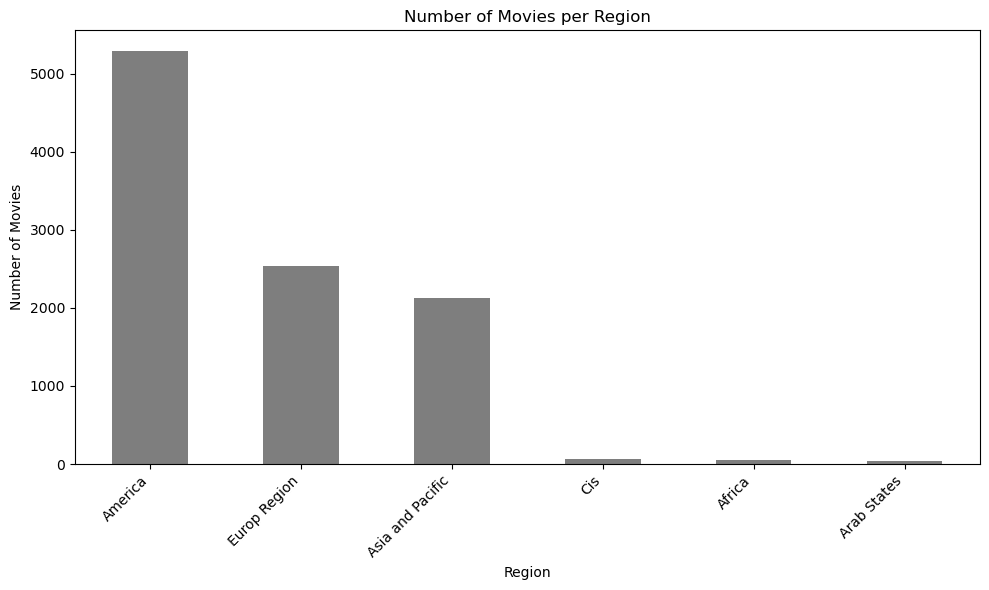

In [37]:
flattened_regions = filtered_df_for_topics['Region'].explode()
movies_per_region = flattened_regions.value_counts()
# Plot the number of movies per region
plt.figure(figsize=(10, 6))
movies_per_region.plot(kind='bar', color='#7e7e7e')
plt.title('Number of Movies per Region')
plt.xlabel('Region')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

In [38]:
print("Count of movies per region:")
print(movies_per_region)

Count of movies per region:
America             5292
​Europ Region       2538
Asia and Pacific    2121
Cis                   67
Africa                48
​Arab States          34
Name: Region, dtype: int64


In [39]:
import plotly.express as px

# Sort the DataFrame by 'Release date'

exploded_df = filtered_df_for_topics.explode('Region').sort_values('Release date')
exploded_df['Release date'] = pd.to_datetime(exploded_df['Release date']).dt.year

# Create a DataFrame suitable for Plotly
plotly_df = exploded_df.groupby(['Region', 'Release date']).size().reset_index(name='Number of Movies')
# Interactive Plot
fig = px.line(plotly_df, x='Release date', y='Number of Movies', color='Region',
              title='Interactive Plot of Movies per Year for Each Region',
              labels={'Release date': 'Release Year', 'Number of Movies': 'Count'})

fig.update_xaxes(rangeslider_visible=True)
fig.show()

We can notive here that there are not enough movies to make an analysis for CIS region, Arab States and Africa thus we will do our topic modelling analysis on the other three region.

#### 4.2.3 Number of movies per release date for each region

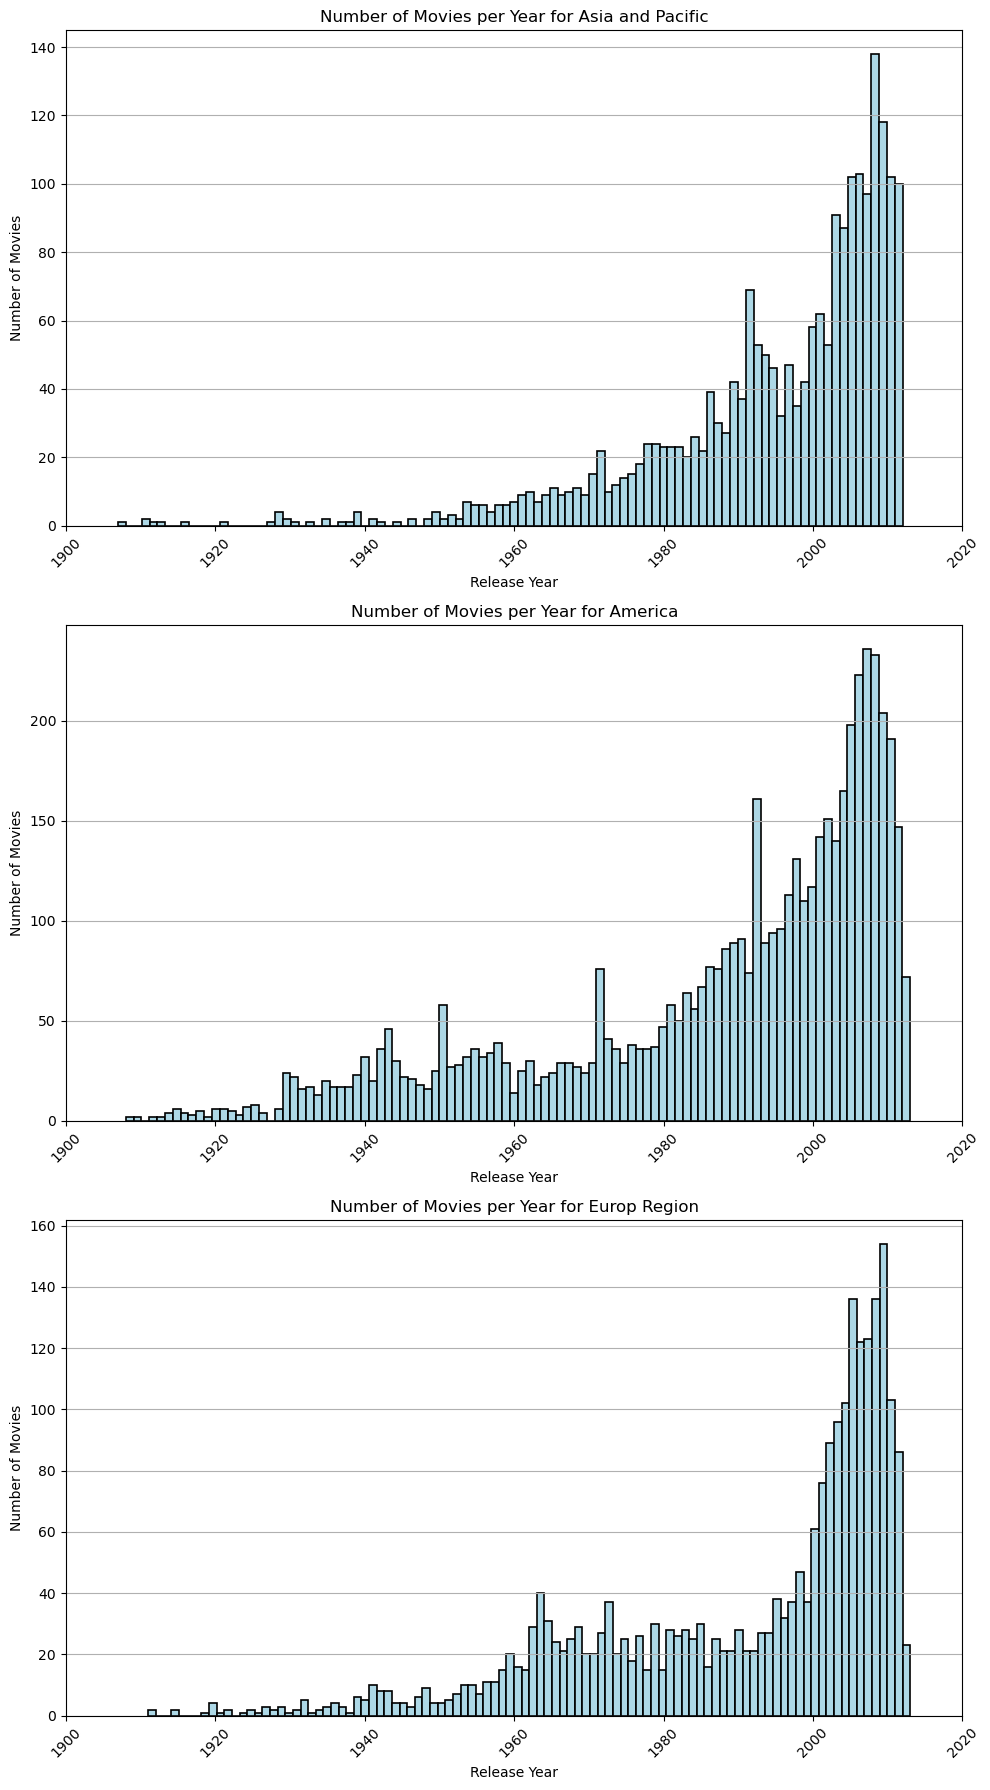

In [49]:
movies_per_year_per_region = (exploded_df.groupby(['Region', 'Release date'])
                                        .size()
                                        .unstack(fill_value=0))
unique_regions = exploded_df['Region'].unique()[:3]
fig, axes = plt.subplots(nrows=len(unique_regions), figsize=(10, 6 * len(unique_regions)))


for i, region in enumerate(unique_regions):
    # Select data for the current region
    region_data = exploded_df[exploded_df['Region'] == region]['Release date'].sort_values()
    axes[i].hist(region_data, bins=100, linewidth=1.2, edgecolor='black', color='lightblue')
    axes[i].set_xlabel('Release Year')
    axes[i].set_ylabel('Number of Movies')
    axes[i].set_title(f'Number of Movies per Year for {region}')
    axes[i].set_xticks(axes[i].get_xticks())
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(axis='y')

plt.tight_layout()
plt.show()
    

### **.3 Genre association: Are there specific genres associated to terrorism movies?**

### **2.4 Emotional depiction: How do movies emotionally depict terrorism, and are there identifiable patterns in the portrayal of emotions like fear, anger, empathy, or sadness? Additionally, do the emotional tones in the cinematic representation of terrorism differ between specific countries/regions?**